# Exercise: Imbalanced data model bias

In this exercise, we take a closer look at *imbalanced datasets*, what effects they have on predictions, and how they can be addressed.

We also employ *confusion matrices* to evaluate model updates.

## Data visualization

Just like in the previous exercise, we use a dataset that represents different classes of objects found on the mountain:

In [1]:
import pandas
#!wget https://raw.githubusercontent.com/MicrosoftDocs/mslearn-introduction-to-machine-learning/main/graphing.py
#!wget https://raw.githubusercontent.com/MicrosoftDocs/mslearn-introduction-to-machine-learning/main/Data/snow_objects.csv
#!wget https://raw.githubusercontent.com/MicrosoftDocs/mslearn-introduction-to-machine-learning/main/Data/snow_objects_balanced.csv

#Import the data from the .csv file
url = "https://raw.githubusercontent.com/MicrosoftDocs/mslearn-introduction-to-machine-learning/main/Data/snow_objects.csv"
dataset = pandas.read_csv(url, delimiter="\t")

# Let's have a look at the data
dataset

,size,roughness,color,motion,label
0,50.959361,1.318226,green,0.054290,tree
1,60.008521,0.554291,brown,0.000000,tree
2,20.530772,1.097752,white,1.380464,tree
3,28.092138,0.966482,grey,0.650528,tree
4,48.344211,0.799093,grey,0.000000,tree
...,...,...,...,...,...
2195,1.918175,1.182234,white,0.000000,animal
2196,1.000694,1.332152,black,4.041097,animal
2197,2.331485,0.734561,brown,0.961486,animal
2198,1.786560,0.707935,black,0.000000,animal


Recall that we have an *imbalanced dataset*. Some classes are much more frequent than others:

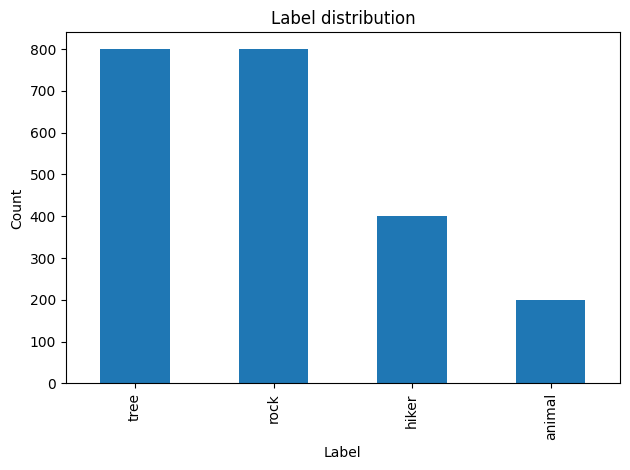

In [2]:
import matplotlib.pyplot as plt

# Count the number of occurrences of each label
label_counts = dataset['label'].value_counts()

# Plot the histogram
label_counts.plot(kind='bar')

plt.title("Label distribution")
plt.xlabel("Label")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

## Using binary classification

For this exercise, we build a *binary classification model*. We want to predict if objects in the snow are "hikers" or "not-hikers".

To do that, we first need to add another column to our dataset and set it to `True` where the original label is `hiker`, and `False` to anything else:


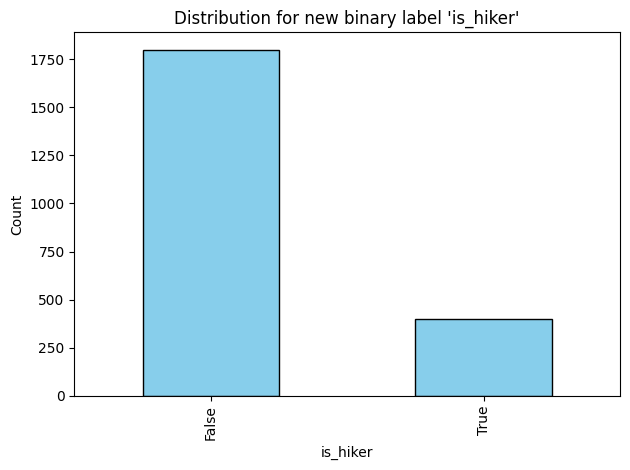

In [3]:
# Add a new label with true/false values to our dataset
dataset["is_hiker"] = dataset.label == "hiker"

# Plot frequency for new label
color_counts = dataset['is_hiker'].value_counts()

# Plot the histogram
color_counts.plot(kind='bar', color='skyblue', edgecolor='black')

plt.title("Distribution for new binary label 'is_hiker'")
plt.xlabel("is_hiker")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

We now have only two classes of labels in our dataset, but we made it even more imbalanced.

Let's train the random forest model using `is_hiker` as the target variable, then measure its accuracy on both *train* and *test* sets:

In [4]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
# import matplotlib.pyplot as plt
# from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import accuracy_score

# Custom function that measures accuracy on different models and datasets
# We will use this in different parts of the exercise
def assess_accuracy(model, dataset, label):
    """
    Asesses model accuracy on different sets
    """ 
    actual = dataset[label]        
    predictions = model.predict(dataset[features])
    acc = accuracy_score(actual, predictions)
    return acc

# Split the dataset in an 70/30 train/test ratio. 
train, test = train_test_split(dataset, test_size=0.3, random_state=1, shuffle=True)

# define a random forest model
model = RandomForestClassifier(n_estimators=1, random_state=1, verbose=False)

# Define which features are to be used (leave color out for now)
features = ["size", "roughness", "motion"]

# Train the model using the binary label
model.fit(train[features], train.is_hiker)

print("Train accuracy:", assess_accuracy(model,train, "is_hiker"))
print("Test accuracy:", assess_accuracy(model,test, "is_hiker"))

Train accuracy: 0.9532467532467532
Test accuracy: 0.906060606060606


Accuracy looks good for both *train* and *test* sets, but remember that this metric is not an absolute measure of success.

We should plot a confusion matrix to see how the model is actually doing:

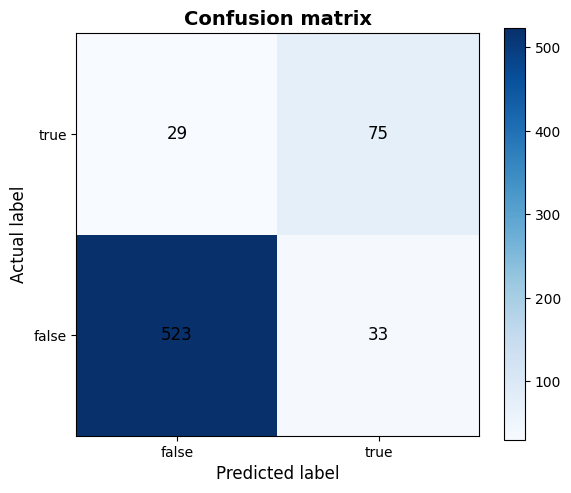

In [6]:
# sklearn has a very convenient utility to build confusion matrices
import numpy as np
from sklearn.metrics import confusion_matrix

# Calculate actual and predictions
actual = test.is_hiker
predictions = model.predict(test[features])

# Build confusion matrix (non-normalized)
cm = confusion_matrix(actual, predictions, normalize=None)

# Unique labels sorted
unique_targets = sorted(list(test["is_hiker"].unique()))

# Convert labels to lowercase strings for display
labels = [str(s).lower() for s in unique_targets]

fig, ax = plt.subplots(figsize=(6, 5))

# Plot confusion matrix as a heatmap
cax = ax.imshow(cm, interpolation='nearest', cmap='Blues')

# Add colorbar
fig.colorbar(cax)

# Add annotations in each cell
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, cm[i, j], ha='center', va='center', color='black', fontsize=12)

# Set axis ticks and labels
ax.set_xticks(np.arange(len(labels)))
ax.set_yticks(np.arange(len(labels)))
ax.set_xticklabels(labels)
ax.set_yticklabels(labels)

# Labels and title
ax.set_xlabel("Predicted label", fontsize=12)
ax.set_ylabel("Actual label", fontsize=12)
ax.set_title("Confusion matrix", fontsize=14, fontweight='bold')

# Invert y-axis to match "category descending" order from plotly
ax.invert_yaxis()

plt.tight_layout()
plt.show()

The confusion matrix shows us that, despite the reported metrics, the model is not incredibly precise.

Out of the 660 samples present in the *test* set (30% of the total samples), it predicted `29` *false negatives* and `33` _false positives_.

More importantly, look at the bottom row, which shows what happened when the model was shown information about a hiker: it got the answer wrong almost 40% of the time. This means it wouldn't correctly identify almost 40% of the people on the mountain!  

What happens if we used this model to make predictions on balanced sets?

Let's load a dataset with an equal number of outcomes for "hikers" and "non-hikers", then use that data to make predictions:

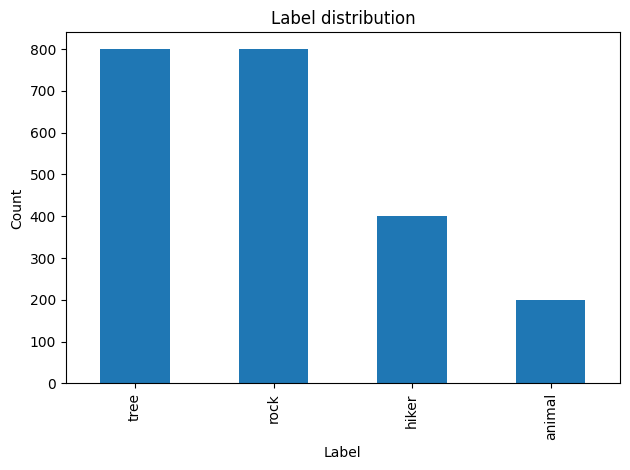

In [8]:
# Load and print unbiased set
#Import the data from the .csv file
url1 = "https://raw.githubusercontent.com/MicrosoftDocs/mslearn-introduction-to-machine-learning/main/Data/snow_objects_balanced.csv"
balanced_dataset = pandas.read_csv(url1, delimiter="\t")

# Count the number of occurrences of each label
label_counts = dataset['label'].value_counts()

# Plot the histogram
label_counts.plot(kind='bar')

plt.title("Label distribution")
plt.xlabel("Label")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

This new dataset is balanced among the classes, but for our purposes we want it balanced between hikers and non-hikers. 

For simplicity, let's take the hikers plus a random sampling of the non-hikers.

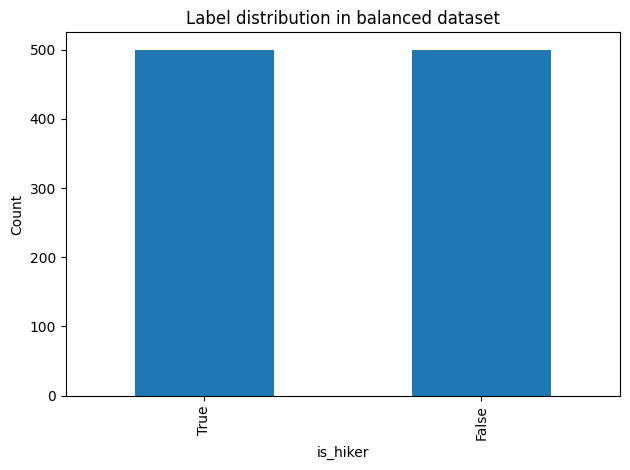

In [9]:
# Add a new label with true/false values to our dataset
balanced_dataset["is_hiker"] = balanced_dataset.label == "hiker"

hikers_dataset = balanced_dataset[balanced_dataset["is_hiker"] == 1] 
nonhikers_dataset = balanced_dataset[balanced_dataset["is_hiker"] == False] 

# take a random sampling of non-hikers the same size as the hikers subset
nonhikers_dataset = nonhikers_dataset.sample(n=len(hikers_dataset.index), random_state=1)
balanced_dataset = pandas.concat([hikers_dataset, nonhikers_dataset])

# Count the number of occurrences of each label
label_counts = balanced_dataset['is_hiker'].value_counts()

# Plot the histogram
label_counts.plot(kind='bar')

plt.title("Label distribution in balanced dataset")
plt.xlabel("is_hiker")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

You note the `is_hiker` label has the same number of `True` and `False` for both classes. We're now using a *class balanced dataset*.

Let's run predictions on this set using the previously trained model:

In [10]:
# Test the model using a balanced dataset
actual = balanced_dataset.is_hiker
predictions = model.predict(balanced_dataset[features])

# Build and print our confusion matrix, using the actual values and predictions 
# from the test set, calculated in previous cells
cm = confusion_matrix(actual, predictions, normalize=None)

# Print accuracy using this set
print("Balanced set accuracy:", assess_accuracy(model,balanced_dataset, "is_hiker"))

Balanced set accuracy: 0.754


As expected, we get a noticeable drop in accuracy using a different set.

Again, let's visually analyze its performance:

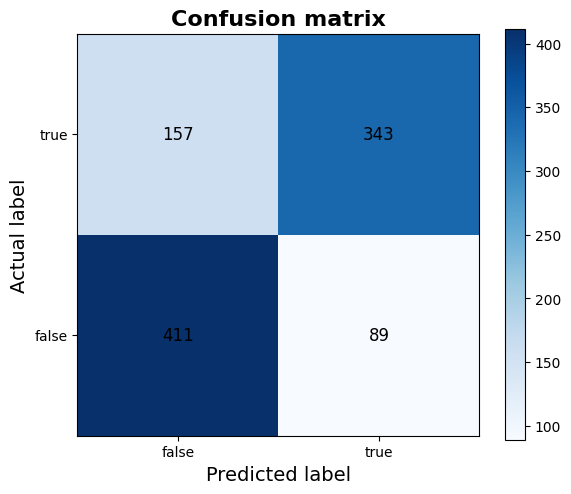

In [11]:
# plot new confusion matrix
# Get sorted list of unique targets as lowercase strings
unique_targets = sorted(list(balanced_dataset["is_hiker"].unique()))
labels = [str(s).lower() for s in unique_targets]

fig, ax = plt.subplots(figsize=(6, 5))

# Show confusion matrix as heatmap
cax = ax.imshow(cm, interpolation='nearest', cmap='Blues')

# Add colorbar (scale)
fig.colorbar(cax)

# Annotate each cell with the numeric value
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, cm[i, j], ha='center', va='center', color='black', fontsize=12)

# Set axis ticks and labels
ax.set_xticks(np.arange(len(labels)))
ax.set_yticks(np.arange(len(labels)))
ax.set_xticklabels(labels)
ax.set_yticklabels(labels)

# Set axis labels and title
ax.set_xlabel("Predicted label", fontsize=14)
ax.set_ylabel("Actual label", fontsize=14)
ax.set_title("Confusion matrix", fontsize=16, fontweight='bold')

# Invert y-axis to match "category descending" order from plotly
ax.invert_yaxis()

plt.tight_layout()
plt.show()

The confusion matrix confirms the poor accuracy using this dataset, but why is this happening when we had such excellent metrics in the earlier *train* and *test* sets?

Recall that the first model was heavily imbalanced. The "hiker" class made up roughly 22% of the outcomes.

When such an imbalance happens, classification models don't have enough data to learn the patterns for the minority __class__, and as a consequence become biased towards the __majority__ class!

Imbalanced sets can be addressed in a number of ways:

- Improving data selection
- Resampling the dataset
- Using weighted classes

For the next exercise, we focus on the last option.

## Using class weights to balance dataset

We can assign different *weights* to the majority and minority classes, according to their distribution, and modify our training algorithm so that it takes that information into account during the training phase.

It will then penalize errors when the minority class is misclassified, in essence "forcing" the model to better learn their features and patterns.

To use weighted classes, we have to retrain our model using the original *train* set, but this time telling the algorithm to use weights when calculating errors:


In [12]:
# Import function used in calculating weights
from sklearn.utils import class_weight

# Retrain model using class weights
# Using class_weight="balanced" tells the algorithm to automatically calculate weights for us
weighted_model = RandomForestClassifier(n_estimators=1, random_state=1, verbose=False, class_weight="balanced")
# Train the weighted_model using binary label
weighted_model.fit(train[features], train.is_hiker)

print("Train accuracy:", assess_accuracy(weighted_model,train, "is_hiker"))
print("Test accuracy:", assess_accuracy(weighted_model, test, "is_hiker"))

Train accuracy: 0.9525974025974026
Test accuracy: 0.9166666666666666


After using the weighted classes, the *train* accuracy remained almost the same, while the *test* accuracy showed a small improvement (roughly 1%).

Let's see if results are improved at all using the __balanced__ set for predictions again:


In [13]:
print("Balanced set accuracy:", assess_accuracy(weighted_model, balanced_dataset, "is_hiker"))

# Test the weighted_model using a balanced dataset
actual = balanced_dataset.is_hiker
predictions = weighted_model.predict(balanced_dataset[features])

# Build and print our confusion matrix, using the actual values and predictions 
# from the test set, calculated in previous cells
cm = confusion_matrix(actual, predictions, normalize=None)


Balanced set accuracy: 0.796


The accuracy for the balanced set increased roughly 4%, but we should still try to to visualize and understand the new results.

## Final confusion matrix

We can now plot a final confusion matrix, representing predictions for a *balanced dataset*, using a model trained on a *weighted class dataset*:

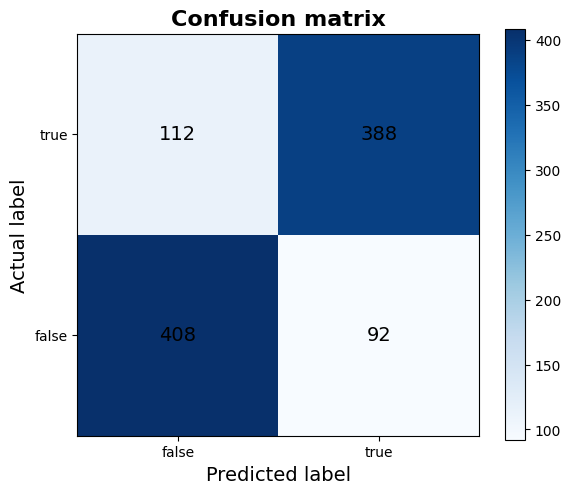

In [14]:
# Plot the matrix above as a heatmap with annotations (values) in its cells

fig, ax = plt.subplots(figsize=(6, 5))

# Display the confusion matrix as a heatmap
cax = ax.imshow(cm, interpolation='nearest', cmap='Blues')

# Add colorbar for scale
fig.colorbar(cax)

# Annotate each cell with its value
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, cm[i, j], ha='center', va='center', color='black', fontsize=14)

# Set axis ticks and labels
ax.set_xticks(np.arange(len(labels)))
ax.set_yticks(np.arange(len(labels)))
ax.set_xticklabels(labels)
ax.set_yticklabels(labels)

# Label the axes
ax.set_xlabel("Predicted label", fontsize=14)
ax.set_ylabel("Actual label", fontsize=14)

# Set the title
ax.set_title("Confusion matrix", fontsize=16, fontweight='bold')

# Invert the y-axis to match "category descending" order in Plotly
ax.invert_yaxis()

plt.tight_layout()
plt.show()

While the results might look a bit disappointing, we now have 21% wrong predictions (FNs + FPs), against 25% from the previous experiment.

Correct predictions (TPs + TNs) went from 74.7% to 78.7%.

Is an all around 4% improvement significant or not?

Remember that we had relatively little data to train the model, and the features we have available may still be so similar for different samples (for example, hikers and animals tend to be small, non-rough and move a lot), that despite our efforts, the model still has some difficulty making correct predictions.

We only had to change a single line of code to get better results, so it seems worth the effort!



## Summary

This was a long exercise, where we covered the following topics:

- Creating new label fields so we can perform *binary classification* using a dataset with multiple classes.
- How training on *imbalanced sets* can have a negative effect in perfomance, especially when using unseen data from *balanced datasets*.
- Evaluating results of *binary classification* models using a confusion matrix.
- Using weighted classes to address class imbalances when training a model and evaluating the results.

